# Advection Diffusion

In [20]:
import torch
from matplotlib import pyplot as plt
import numpy as np
from src.forward_models.advdiff import AdvDiffSolver
from src.sampler.distributions import BoxUniformSampler

In [21]:
device = 'cpu'
n_grids = 20
len_episode = 50
dx = 0.1
dt = 0.02
noise_std = 0. #1e-3

torch.manual_seed(1234)
np.random.seed(1234)

# known parameters
range_init_mag = (0.5, 1.5)
range_dcoeff = (1e-2, 1e-1) # diffusion_coeff
lb = torch.tensor([range_init_mag[0], range_dcoeff[0]], device=device)
ub = torch.tensor([range_init_mag[1], range_dcoeff[1]], device=device)

# unknown/missing term
range_ccoeff = (1e-2, 1e-1) # unknown_params, convection_coeff 
c_coeff_lb, c_coeff_ub = torch.tensor([range_ccoeff[0]], device=device), torch.tensor([range_ccoeff[1]], device=device)

# Sampler
known_params_sampler = BoxUniformSampler(lb, ub)
n_samples = 100
samples = known_params_sampler.sample((n_samples,))
# init conditions and boundaries
init_conds= samples[:, 0].view(-1, 1)
# Simple model simulations
x_grid = torch.linspace(0.0, dx * (n_grids - 1), n_grids, device=device) # 20 
init_sin = torch.sin(x_grid / x_grid[-1] * torch.pi)
print(init_sin.shape)
# broadcast init_conds * init_sin for boundaries conditions
init_conds = init_conds * init_sin # n_samples x 20
print("initial condition shape", init_conds.shape)
simple_model = AdvDiffSolver(dx=dx, dt=dt, len_episode=len_episode, n_grids=n_grids, noise_std=None, device=device, method="rk4")
params_a = samples[:, 1].view(-1, 1)
d = params_a.shape[-1]
params_a = params_a.reshape(-1, 1, d)
params_a = params_a.repeat(1, n_grids, 1) #.reshape(-1, ic_params.shape[-1])
params_a = params_a.view(-1, d)
print(f"params_a shape: {params_a.shape}")
x_res = simple_model(init_conds=init_conds, params=params_a)
x_sims = x_res["x"]
print(f"simulations shape: {x_sims.shape}")

torch.Size([20])
initial condition shape torch.Size([100, 20])
params_a shape: torch.Size([2000, 1])
simulations shape: torch.Size([100, 20, 50])


In [22]:
params_a.shape

torch.Size([2000, 1])

In [23]:
print(params_a.reshape(-1, 20)[:3].unique(dim=0).shape)
print(params_a.reshape(-1, 20)[:1].unique())

torch.Size([3, 20])
tensor([0.0462])


In [24]:
# Complete model simulations with sampled convection term (stochastic one-to-many)
unknown_params_sampler = BoxUniformSampler(c_coeff_lb, c_coeff_ub, device=device)
noisy_samples = 2
# Sample unknown parameters
unknown_params = unknown_params_sampler.sample((noisy_samples,))
print(f"unknown_params : {unknown_params}, {unknown_params.shape}")
unknown_params = unknown_params.repeat(params_a.shape[0], 1)
unknown_params = unknown_params.reshape(-1, unknown_params.shape[-1])
print(f"unknown_params shape: {unknown_params.shape}")

# Broadcast init_conds for noisy samples
new_init_cond = init_conds.reshape(-1, 1, init_conds.shape[-1])
new_init_cond = new_init_cond.repeat(1, noisy_samples, 1)
new_init_cond = new_init_cond.reshape(-1, new_init_cond.shape[-1])
print(f"new_init_cond shape: {new_init_cond.shape}")

# Full parameters (known + unknown)
params = params_a.reshape(-1, 1, params_a.shape[-1]).repeat(1, noisy_samples, 1).reshape(-1, params_a.shape[-1])
params = torch.cat([params, unknown_params], dim=-1)
print(f"params shape: {params.shape}")

unknown_params : tensor([[0.0444],
        [0.0875]]), torch.Size([2, 1])
unknown_params shape: torch.Size([4000, 1])
new_init_cond shape: torch.Size([200, 20])
params shape: torch.Size([4000, 2])


In [25]:
print(f"Params shape: {params.shape}")
params[:200].unique(dim=0)

Params shape: torch.Size([4000, 2])


tensor([[0.0398, 0.0444],
        [0.0398, 0.0875],
        [0.0430, 0.0444],
        [0.0430, 0.0875],
        [0.0462, 0.0444],
        [0.0462, 0.0875],
        [0.0521, 0.0444],
        [0.0521, 0.0875],
        [0.0731, 0.0444],
        [0.0731, 0.0875]])

In [26]:
new_init_cond[:5].unique(dim=0).shape

torch.Size([3, 20])

In [27]:
new_init_cond.shape, params.shape

(torch.Size([200, 20]), torch.Size([4000, 2]))

In [28]:
complete_model = AdvDiffSolver(dx=dx, dt=dt, len_episode=len_episode,  n_grids=n_grids, noise_std=noise_std, device=device, method="rk4")
y_res = complete_model(init_conds=new_init_cond, params=params)
y_sims = y_res["x"]
print(f"simulations shape: {y_sims.shape}")

simulations shape: torch.Size([200, 20, 50])


69
Simple Model parameters 
tensor([0.0895])
Complete Model parameters 
tensor([[[0.0895, 0.0444],
         [0.0895, 0.0875]]])


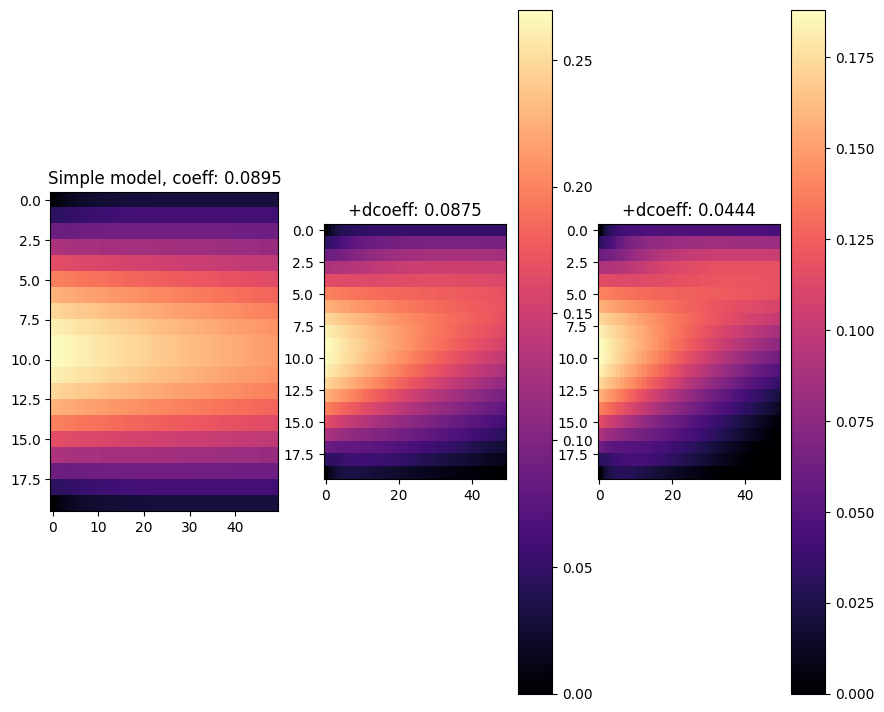

In [45]:
random_idx = np.random.randint(0, n_samples)
print(random_idx)
#vmax = y_sims[random_idx: random_idx+noisy_samples].max()
kwargs = {'vmin':0.0, 'aspect':3.5, 'cmap':'magma', 'interpolation':'none'}
fig, axes = plt.subplots(1, noisy_samples+1, figsize=(10, 20))

print(f"Simple Model parameters \n{params_a.reshape(-1, 20)[random_idx].unique()}")
print(f"Complete Model parameters \n{params.reshape(-1, 20, noisy_samples, 2)[random_idx].unique(dim=0)}")

axes[0].imshow(x_sims[random_idx].detach().cpu().numpy(), **kwargs)
axes[0].set_title(f"Simple model, coeff: {params_a.reshape(-1, 20)[random_idx].unique().item():.4f}")

for j in range(noisy_samples):
    i = random_idx + j
    pos = axes[j+1].imshow(x_sims[random_idx].detach().cpu().numpy() - y_sims[i].detach().cpu().numpy(), **kwargs)
    axes[j+1].set_title(f"+dcoeff: {unknown_params[i].item():.4f}")
    fig.colorbar(pos, ax=axes[j+1], shrink=5)

# Load Dataset

In [29]:
## Inspection of the training data
tr_data = "/home/jeet/Documents/phd/dmml/ot-model-misspecification/datasets/forward_models/advdiff/one_to_many/training/data_7294c286476eee876c2339f2ad3c5e4c"
n_stoch_samples = 5
tr_data = torch.load(tr_data)
tr_params = tr_data["params"]
tr_init_conds = tr_data["init_conds"]
tr_sims = tr_data["x"]
tr_sims = tr_sims.reshape(-1, n_stoch_samples, 20, 50)
tr_params = tr_params.reshape(-1, n_stoch_samples, 20, 2)
tr_init_conds = tr_init_conds.reshape(-1, n_stoch_samples, 20)

phys_solver = AdvDiffSolver(
    dx=0.1,
    dt=0.02,
    n_grids=20,
    len_episode=50,
    method="rk4",
    device="cpu"
)

In [30]:
tmp = tr_sims.reshape(-1, 20, 50)

In [ ]:
v_max = tr_sims.max().item()
v_max

In [ ]:
torch.min(tmp, dim=-1)[0].min(dim=0)

In [ ]:
print(f"Parameter shapes {tr_params.shape}")
print(tr_params[5, :, 1, 1])
print(tr_sims.shape)
print(tr_params[5, :, :, 1].unique(dim=-1))
print(f"Initial condition shape {tr_init_conds.shape}")
print(f"Simulations shape {tr_sims.shape}")

In [ ]:
plot_samples = 2
v_max = tr_sims.max().item()
for j in range(0, plot_samples):
    random_idx = 181 #np.random.randint(0, tr_sims.shape[0])
    print(random_idx)
    #vmax = tr_sims[random_idx, :noisy_samples].max()
    #'vmax':vmax
    kwargs = {'vmin':0.0, 'aspect':3.5, 'cmap':'magma', 'interpolation':'none'} #'vmax': v_max
    fig, axes = plt.subplots(1, noisy_samples+1, figsize=(30, 15))
    #plt.subplots_adjust(hspace=0.01)
    # Simple Model
    X_params = tr_params[random_idx, 0, :, :1].unsqueeze(0)
    X_init_conds = tr_init_conds[random_idx, 0, :].unsqueeze(0)
    X_sims = phys_solver(init_conds=X_init_conds, params=X_params)["x"]

    print(X_params.shape, X_init_conds.shape)
    param_0 = X_params[0, :].unique()
    print(f"Simple Model parameters \n{param_0}")
    c_params = tr_params[random_idx, :, :, 1].unique(dim=-1)
    print(f"Complete Model parameters \n{c_params}")

    axes[0].imshow(X_sims[0].detach().cpu().numpy(), **kwargs)
    axes[0].set_title(f"Simple model, coeff: {param_0.item():.4f}")

    for i in range(noisy_samples):
        # Target
        axes[i+1].imshow(tr_sims[random_idx, i].detach().cpu().numpy(), **kwargs)
        axes[i+1].set_title(f"+dcoeff: {c_params[i][0]:.4f}")
    
    plt.show()